# Project "United Outdoors"
---
`Datawarehouse: Implementatie & merges` | `Versie 3: 5/21/2024`

## Imports

In [16]:

import warnings
import os.path
import pandas as pd
import pyodbc as pbc
import numpy as np
import sqlite3 as sqlite

## Kernel & package settings

In [3]:
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Verander dit naar de gegevens van de SQL Server database
DB = {'servername': 'DESKTOP-26VG8Q3',
      'database': 'Warehouse'}

# Verander dit naar het relatieve pad naar de assets
base_path = '.' # Default: assets staan op hetzelfde pad als dit bestand in de folder "assets"

## Database verbinding
- ***SQL Server:*** `Datawarehouse` | `Northwind` | `AdventureWorks`
- ***SQLite:*** `AENC`

In [4]:
# Fix voor hierachyid
def HandleHierarchyId(v):
      return str(v)

In [5]:
def asset(path):
    return os.path.join(base_path, 'assets', path)

dwh = pbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')
nw = pbc.connect('DRIVER={SQL Server};SERVER=DESKTOP-26VG8Q3;DATABASE=''NorthWind'';Trusted_Connection=yes')
aw = pbc.connect('DRIVER={SQL Server};SERVER=DESKTOP-26VG8Q3;DATABASE=''AdventureWorks2019'';Trusted_Connection=yes')
aw.add_output_converter(-151, HandleHierarchyId) # Fix..
aenc = sqlite.connect("C:\\Users\\Nick\\Desktop\\school\\AENC.sqlite")





## Util functies
Hier staan een aantal functies die redundancy tegen gaan in de code, zodat we dit niet telkens hoeven herhalen. 

In [6]:
currentConnection = None

# Leest een SQL tabel uit en geeft een dataframe terug
def readTable(tableName, conn=None):
    global currentConnection
    
    if conn is not None:
        currentConnection = conn
    
    return pd.read_sql(("SELECT * FROM {};".format(tableName)), currentConnection)

def injectTable(dataframe, tableName, keys, conn=None):
    dataframe = dataframe.replace({np.nan: None})
    
    global currentConnection
    
    if conn is not None:
        currentConnection = conn
    
    cursor = currentConnection.cursor()
    cursor.execute(f'DELETE FROM {tableName}')
    
    parameterNotation = ",".join("?" for _ in range(len(keys)))

    for index, row in dataframe.iterrows():
        try:
            data = []
            
            for key in keys:
                data.append(row[key])
                
            
            query = f"INSERT INTO {tableName} VALUES ({parameterNotation})"
            cursor.execute(query, tuple(data))
        except pbc.Error as e:
            print(f"Error inserting row {index}@{tableName}: {e}")

    currentConnection.commit()
    cursor.close()

## Uitlezen data
Hier maken we een verzameling van alle tabellen die voor ons beschikbaar zijn en zetten deze in dataframes.

### Northwind

In [110]:
categories = readTable("Categories", nw)
northwind_customers = readTable("Customers")
northwind_employees = readTable("Employees")
employeeTerritories = readTable("EmployeeTerritories")
northwind_customer_demographics = readTable("CustomerDemographics")
northwind_customer_demo = readTable("CustomerCustomerDemo")
orderDetails = readTable("[Order Details]")
orders = readTable("Orders")
northwind_products = readTable("Products")
northwind_region = readTable("Region")
shippers = readTable("Shippers")
suppliers = readTable("Suppliers")
territories = readTable("Territories")

### AdventureWorks

In [137]:
# Human Resources
aw_department = readTable("HumanResources.Department", aw)
AdventureWorks_employee = readTable("HumanResources.Employee")
employeeDepartmentHistory = readTable("HumanResources.EmployeeDepartmentHistory")
employeePayHistory = readTable("HumanResources.EmployeePayHistory")
jobCandidate = readTable("HumanResources.JobCandidate")
shift = readTable("HumanResources.Shift")


# Person
address = readTable("Person.Address")
addressType = readTable("Person.AddressType")
businessEntity = readTable("Person.BusinessEntity")
businessEntityAddress = readTable("Person.BusinessEntityAddress")
businessEntityContact = readTable("Person.BusinessEntityContact")
contactType = readTable("Person.ContactType")
countryRegion = readTable("Person.CountryRegion")
emailAddress = readTable("Person.EmailAddress")
person = readTable("Person.Person")
personPhone = readTable("Person.PersonPhone")
phoneNumberType = readTable("Person.PhoneNumberType")
stateProvince = readTable("Person.StateProvince")
password = readTable("Person.Password")
 

# Production
billOfMaterials = readTable("Production.BillOfMaterials")
culture = readTable("Production.Culture")
document = readTable("Production.Document")
illustration = readTable("Production.Illustration")
location = readTable("Production.Location")
Adventureworks_product = readTable("Production.Product")
productCategory = readTable("Production.ProductCategory")
productCostHistory = readTable("Production.ProductCostHistory")
productDescription = readTable("Production.ProductDescription")
productDocument = readTable("Production.ProductDocument")
productInventory = readTable("Production.ProductInventory")
productListPriceHistroy = readTable("Production.ProductListPriceHistory")
productModelProductDescriptionCulture = readTable("Production.ProductModelProductDescriptionCulture")
productPhoto = readTable("Production.ProductPhoto")
productProductPhoto = readTable("Production.ProductProductPhoto")
productReview = readTable("Production.ProductReview")
productSubcategory = readTable("Production.ProductSubcategory")
scrapReason = readTable("Production.ScrapReason")
transactionHistory = readTable("Production.TransactionHistory")
transactionHistoryArchive = readTable("Production.TransactionHistoryArchive")
unitMeasure = readTable("Production.UnitMeasure")
workOrder = readTable("Production.WorkOrder")
workOrderRouting = readTable("Production.WorkOrderRouting")
productModelIllustration = readTable("Production.ProductModelIllustration")
productModel = readTable("Production.ProductModel")

# Purchasing
productVendor = readTable("Purchasing.ProductVendor")
purchaseOrderDetail = readTable("Purchasing.PurchaseOrderDetail")
purchaseOrderHeader = readTable("Purchasing.PurchaseOrderHeader")
shipMethod = readTable("Purchasing.ShipMethod")
vendor = readTable("Purchasing.Vendor")

# Sales
countryRegionCurrency = readTable("Sales.CountryRegionCurrency")
creditCard = readTable("Sales.CreditCard")
currency = readTable("Sales.Currency")
currencyRate = readTable("Sales.CurrencyRate")
customer = readTable("Sales.Customer")
personalCreditCard = readTable("Sales.PersonCreditCard")
salesOrderDetail = readTable("Sales.SalesOrderDetail")
salesOrderHeader = readTable("Sales.SalesOrderHeader")
salesOrderHeaderSalesReason = readTable("Sales.SalesOrderHeaderSalesReason")
salesPerson = readTable("Sales.SalesPerson")
salesPersonQuotaHistory = readTable("Sales.SalesPersonQuotaHistory")
salesReason = readTable("Sales.SalesReason")
salesTaxRate = readTable("Sales.SalesTaxRate")
salesTerritory = readTable("Sales.SalesTerritory")
salesTerritoryHistory = readTable("Sales.SalesTerritoryHistory")
shippingCartItem = readTable("Sales.ShoppingCartItem")
specialOffer = readTable("Sales.SpecialOffer")
specialOfferProduct = readTable("Sales.SpecialOfferProduct")
store = readTable("Sales.Store")

### AENC

In [85]:
bonus = readTable("bonus", aenc)
AENC_customer = readTable("customer")
department = readTable("department")
AENC_employee = readTable("employee")
AENC_product = readTable("product")
AENC_region = readTable("region")
sales_order = readTable("sales_order")
sales_order_item = readTable("sales_order_item")
state = readTable("state")

,id,name,description,prod_size,color,quantity,unit_price,picture_name,Category
0,300,Tee Shirt,Tank Top,Small,White,18,9,tshirtw.bmp,Clothes
1,301,Tee Shirt,V-neck,Medium,Orange,39,14,tshirto.bmp,Clothes
2,302,Tee Shirt,Crew Neck,One size fits all,Black,72,14,tshirtb.bmp,Clothes
3,400,Baseball Cap,Cotton Cap,One size fits all,Black,92,9,capb.bmp,Accessories
4,401,Baseball Cap,Wool cap,One size fits all,White,12,10,capw.bmp,Accessories
5,500,Visor,Cloth Visor,One size fits all,White,36,7,visorw.bmp,Accessories
6,501,Visor,Plastic Visor,One size fits all,Black,28,7,visorb.bmp,Accessories
7,600,Sweatshirt,Hooded Sweatshirt,Large,Green,39,24,sshirtg.bmp,Clothes
8,601,Sweatshirt,Zipped Sweatshirt,Large,Blue,32,24,sshirtb.bmp,Clothes
9,700,Shorts,Cotton Shorts,Medium,Black,80,15,shortsb.bmp,Clothes


## Samenvoegen (merge) van data
We voegen enkele tabellen samen met de-normaliseren in gedachten

### Northwind

In [111]:
northwind_employees = pd.merge(northwind_employees, pd.merge(employeeTerritories, pd.merge(territories, northwind_region, how='left', on='RegionID'), how='left', on='TerritoryID'), how='left', on='EmployeeID')
shippers = shippers
northwind_product = pd.merge(northwind_products, suppliers, how='left', on='SupplierID')
northwind_product = pd.merge(northwind_product, categories, how='left', on='CategoryID')
northwind_customers = pd.merge(northwind_customers, pd.merge(northwind_customer_demo, northwind_customer_demographics, how='left', on='CustomerTypeID'), how='left', on='CustomerID')
orders = pd.merge(orders, orderDetails, how='left', on='OrderID')

orders

,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,ProductID,UnitPrice,Quantity,Discount
0,10248,VINET,5,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France,11,14.00,12,0.00
1,10248,VINET,5,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France,42,9.80,10,0.00
2,10248,VINET,5,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France,72,34.80,5,0.00
3,10249,TOMSP,6,1996-07-05,1996-08-16,1996-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,None,44087,Germany,14,18.60,9,0.00
4,10249,TOMSP,6,1996-07-05,1996-08-16,1996-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,None,44087,Germany,51,42.40,40,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,11077,RATTC,1,1998-05-06,1998-06-03,NaT,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,NM,87110,USA,64,33.25,2,0.03
2151,11077,RATTC,1,1998-05-06,1998-06-03,NaT,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,NM,87110,USA,66,17.00,1,0.00
2152,11077,RATTC,1,1998-05-06,1998-06-03,NaT,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,NM,87110,USA,73,15.00,2,0.01
2153,11077,RATTC,1,1998-05-06,1998-06-03,NaT,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,NM,87110,USA,75,7.75,4,0.00


### AdventureWorks

In [19]:

personPhone = pd.merge(personPhone, phoneNumberType, on='PhoneNumberTypeID')
person = person
person['fullname'] = person['FirstName'] + ' ' + person['LastName']
password = password
emailAddress = emailAddress
businessEntityContact = pd.merge(businessEntityContact, contactType, on='ContactTypeID').drop("ModifiedDate_x",  axis='columns').drop("ModifiedDate_y",  axis='columns')
businessEntity = businessEntity
businessEntityAddress = businessEntityAddress
addressType = addressType
address = address
countryRegion = countryRegion
stateProvince = stateProvince
purchaseOrderHeader = pd.merge(purchaseOrderDetail, purchaseOrderHeader, on="PurchaseOrderID")

In [ ]:
productModel_merge = pd.merge(productModelIllustration, illustration, on='IllustrationID')
productModel_merge = pd.merge(productModel_merge,productModel, on='ProductModelID')

product_merge = pd.merge(Adventureworks_product, unitMeasure, how='left', left_on='SizeUnitMeasureCode', right_on='UnitMeasureCode')
product_merge = pd.merge(product_merge, productModel, how='left', left_on='ProductModelID', right_on='ProductModelID')
product_merge = pd.merge(product_merge, pd.merge(productSubcategory, productCategory, on='ProductCategoryID'), on='ProductSubcategoryID')

productInventory_merge = pd.merge(productInventory , location, on='LocationID')
productProductPhoto_merge = pd.merge(productProductPhoto , productPhoto , on= 'ProductPhotoID')
productModelProductDescriptionCulture_merge = pd.merge(productModelProductDescriptionCulture, culture, on='CultureID')
productDescription = productDescription
productDocument_merge = pd.merge(productDocument, document, on='DocumentNode')

In [ ]:
vendor_merge = pd.merge(productVendor, unitMeasure, on='UnitMeasureCode')
vendor_merge = pd.merge(vendor, vendor_merge, on='BusinessEntityID')
purchaseOrderHeader = purchaseOrderHeader

In [ ]:
store = store
customer = customer
salesPerson = salesPerson
salesTerritory = salesTerritory
countryRegionCurrency = countryRegionCurrency
currency = currency
salesOrderHeaderSalesReason = salesOrderHeaderSalesReason
specialOfferProduct = specialOfferProduct
salesOrderDetail = salesOrderDetail
billOfMaterials_merge = pd.merge(billOfMaterials, unitMeasure, on='UnitMeasureCode')
currencyRate = currencyRate
salesPersonQuotaHistory = salesPersonQuotaHistory
salesTerritoryHistory = salesTerritoryHistory
salesTaxRate = salesTaxRate
salesOrderHeader = salesOrderHeader

### AENC

In [86]:
AENC_employee = pd.merge(AENC_employee, department, how='left', on='dept_id')
AENC_employee = pd.merge(AENC_employee, state, how='left', left_on='state', right_on='state_id')
AENC_employee
AENC_employee['fullname'] = AENC_employee['emp_fname'] + ' ' + AENC_employee['emp_lname']
AENC_employee = AENC_employee.drop("emp_fname",  axis='columns').drop("emp_lname",  axis='columns')

AENC_product = AENC_product
AENC_customer = pd.merge(AENC_customer, pd.merge(state, AENC_region, how='left', on='region'), how='left', left_on='state', right_on='state_id')
bonus = bonus
sales_order = pd.merge(sales_order, sales_order_item, how='left', on='id')

sales_order

,id,cust_id,order_date,region,sales_rep,line_id,prod_id,quantity,ship_date
0,2001,101,14-Mar-1996 12:00:00 AM,Eastern,299,1,300,12,15-Sep-1996 12:00:00 AM
1,2001,101,14-Mar-1996 12:00:00 AM,Eastern,299,2,301,12,14-Sep-1996 12:00:00 AM
2,2001,101,14-Mar-1996 12:00:00 AM,Eastern,299,3,302,12,14-Sep-1996 12:00:00 AM
3,2002,102,18-Mar-1996 12:00:00 AM,Eastern,467,1,400,24,18-Sep-1996 12:00:00 AM
4,2002,102,18-Mar-1996 12:00:00 AM,Eastern,467,2,401,24,18-Sep-1996 12:00:00 AM
...,...,...,...,...,...,...,...,...,...
1098,2652,174,26-Nov-1998 12:00:00 AM,Central,902,2,300,10,01-Dec-1998 12:00:00 AM
1099,2653,102,17-Jan-1999 12:00:00 AM,Eastern,148,1,301,0,17-Oct-1999 12:00:00 AM
1100,2654,105,26-Feb-1999 12:00:00 AM,South,148,1,301,15,29-Oct-1999 12:00:00 AM
1101,2654,105,26-Feb-1999 12:00:00 AM,South,148,2,302,3,29-Oct-1999 12:00:00 AM


## Injecteren van data in Datawarehouse (DWH)

### Northwind

In [21]:
# Product
keys = ('ProductID', 'ProductName', 'Country', 'Region', 'City', 'PostalCode', 'Address', 'SupplierID', 'CompanyName', 'ContactName', 'ContactTitle', 'Phone', 'Fax', 'HomePage', 'CategoryID', 'CategoryName', 'Description', 'QuantityPerUnit', 'UnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel', 'Discontinued')
injectTable(northwind_product, '[Northwind.Product]', keys, dwh)

# Customer
keys = ('CustomerID', 'Phone', 'Fax', 'Country', 'Region', 'City', 'PostalCode', 'Address', 'CompanyName', 'ContactName', 'ContactTitle', 'CustomerDesc')
injectTable(northwind_customers, '[Northwind.Customer]', keys)

# Employee
keys = ('EmployeeID', 'FullName', 'Country', 'RegionID', 'RegionDescription', 'TerritoryID', 'TerritoryDescription', 'City', 'PostalCode', 'Address', 'Title', 'TitleOfCourtesy', 'BirthDate', 'HireDate', 'Extension', 'ReportsTo', 'PhotoPath')
northwind_employees['FullName'] = northwind_employees['FirstName'] + ' ' + northwind_employees['LastName']
injectTable(northwind_employees, '[Northwind.Employee]', keys)

# Order
keys = ('OrderID', 'ProductID', 'CustomerID', 'EmployeeID', 'OrderDate', 'RequiredDate', 'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress', 'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry', 'UnitPrice', 'Quantity', 'Discount')
injectTable(orders, '[Northwind.Order]', keys)

# Shipper
keys = ('ShipperID', 'CompanyName', 'Phone')
injectTable(shippers, '[Northwind.Shipper]', keys)

### AdventureWorks

#### Person

In [23]:
# StateProvince
keys = ('StateProvinceID', 'StateProvinceCode', 'CountryRegionCode', 'IsOnlyStateProvinceFlag', 'Name', 'TerritoryID')
injectTable(stateProvince, '[AW.StateProvince]', keys)

# CountryRegion
keys = ('CountryRegionCode', 'Name')
injectTable(countryRegion, '[AW.CountryRegion]', keys)

# BusinessEntityAddress
keys = ('BusinessEntityID', 'AddressID', 'AddressTypeID')
injectTable(businessEntityAddress, '[AW.BusinessEntityAddress]', keys)

# BusinessEntityContact
keys = ('BusinessEntityID', 'PersonID', 'ContactTypeID', 'Name_x')
injectTable(businessEntityContact_merge, '[AW.BusinessEntityContact]', keys)

# Emailadress
keys = ('BusinessEntityID', 'EmailAddressID', 'EmailAddress')
injectTable(emailAddress, '[AW.EmailAddress]', keys)

#password
keys = ('BusinessEntityID', 'PasswordHash', 'PasswordSalt')
injectTable(password, '[AW.Password]', keys)

#person
keys = ('BusinessEntityID', 'fullname',  'PersonType', 'NameStyle', 'Title', 'EmailPromotion')
injectTable(person, '[AW.Person]', keys)

#personPhone
keys = ('BusinessEntityID', 'PhoneNumber', 'PhoneNumberTypeID', 'Name_x')
injectTable(personPhone_merge, '[AW.PersonPhone]', keys)

#Address
keys = ('AddressID', 'AddressLine1', 'SpatialLocation', 'AddressLine2', 'City', 'StateProvinceID', 'SpatialLocation')
injectTable(address, '[AW.Address]', keys)

#AddressType
keys = ('AddressTypeID', 'Name')
injectTable(addressType, '[AW.AdressType]', keys)


#### Production

In [27]:
#[AW.Product]
keys = ('ProductID', 'Name_x_x','ProductNumber','MakeFlag','FinishedGoodsFlag','Color','SafetyStockLevel','ReorderPoint','StandardCost','ListPrice','Size','WeightUnitMeasureCode','Weight','DaysToManufacture','ProductLine','Class','Style','SellStartDate','DiscontinuedDate','UnitMeasureCode','Name_y_x','ProductSubcategoryID','Name_x_y','ProductCategoryID','Name_y_y','ProductModelID','Name')
injectTable(product_merge, '[AW.Product]', keys)

#[AW.ScrapReason]
keys = ('ScrapReasonID', 'Name')
injectTable(scrapReason, '[AW.ScrapReason]', keys)

#[AW.SpecialOffer]
keys = ('SpecialOfferID', 'Description','DiscountPct','Type','Category','StartDate','EndDate','MinQty','MaxQty')
injectTable(specialOffer, '[AW.SpecialOffer]', keys)

#[AW.TransactionHistoryArchive]
keys = ('TransactionID', 'ProductID','ReferenceOrderLineID','ReferenceOrderID','TransactionDate','TransactionType','Quantity','ActualCost')
injectTable(transactionHistoryArchive, '[AW.TransactionHistoryArchive]', keys)

#[AW.WorkOrderRouting]
keys = ('WorkOrderID', 'ProductID','OperationSequence','ScheduledStartDate','ScheduledEndDate','ActualStartDate','ActualEndDate','ActualResourceHrs','PlannedCost','ActualCost','LocationID')
injectTable(workOrderRouting, '[AW.WorkOrderRouting]', keys)

#[dbo.AW.WorkOrder]
keys = ('WorkOrderID', 'ProductID','OrderQty','StockedQty','ScrappedQty','StartDate','EndDate','DueDate','ScrapReasonID')
injectTable(workOrder, '[dbo.AW.WorkOrder]', keys)

#[AW.TransactionHistory]
keys = ('TransactionID', 'ReferenceOrderLineID','ReferenceOrderID','TransactionDate','TransactionType','Quantity','ActualCost','ProductID')
injectTable(transactionHistory, '[AW.TransactionHistory]', keys)

#Productreview
keys = ('ProductReviewID', 'ReviewerName','ReviewDate','EmailAddress','Rating','ProductID')
injectTable(productReview, '[AW.ProductReview]', keys)

#ProductListPriceHistory
keys = ('ProductID', 'StartDate', 'EndDate', 'ListPrice')
injectTable(productListPriceHistroy, '[AW.ProductListPriceHistory]', keys)

#productModelProductDescriptionCulture
keys = ('ProductModelID', 'ProductDescriptionID', 'CultureID','Name')
injectTable(productModelProductDescriptionCulture_merge, '[AW.ProductModelProductDescription]', keys)

#ProductCostHistory
keys = ('ProductID', 'StartDate', 'EndDate', 'StandardCost')
injectTable(productCostHistory, '[AW.ProductCostHistory]', keys)

#BusinessEntityContact
keys = ('BusinessEntityID', 'PersonID', 'ContactTypeID','Name')
injectTable(businessEntityContact, '[AW.BusinessEntityContact]', keys)

#BusinessEntityAddress
keys = ('BusinessEntityID', 'AddressID', 'AddressTypeID')
injectTable(businessEntityAddress, '[AW.BusinessEntityAddress]', keys)

#Address
keys = ('AddressID', 'AddressLine1','SpatialLocation', 'AddressLine2', 'City', 'StateProvinceID','PostalCode')
injectTable(address, '[AW.Address]', keys)

#AdressType
keys = ('AddressTypeID', 'Name')
injectTable(addressType, '[AW.AdressType]', keys)

#ProductProductPhoto
keys = ('ProductPhotoID', 'ProductID', 'ThumbnailPhotoFileName', 'LargePhotoFileName', 'Primary')
injectTable(productProductPhoto_merge, '[AW.ProductProductPhoto]', keys)

#ProductInventory
keys = ('ProductID', 'LocationID', 'Name', 'CostRate', 'Availability', 'Shelf', 'Bin', 'Quantity')
injectTable(productInventory_merge, '[AW.ProductInventory]', keys)

#ProductDocument
keys = ('ProductID', 'DocumentNode', 'DocumentLevel', 'Title', 'Owner', 'FolderFlag', 'FileName', 'FileExtension', 'Revision', 'ChangeNumber', 'Status', 'DocumentSummary')
injectTable(productDocument_merge, '[AW.ProductDocument]', keys)

#ProductDescription
keys = ('ProductDescriptionID', 'Description')
injectTable(productDescription, '[AW.ProductDescription]', keys)

#ProductModelIllustration
keys = ('ProductModelID', 'IllustrationID', 'Name', 'CatalogDescription')
injectTable(productModel_merge, '[AW.ProductModelIllustration]', keys)


### Vendor

In [29]:
#[AW.ShipMethod]
keys = ('ShipMethodID', 'Name','ShipBase','ShipRate')
injectTable(shipMethod, '[AW.ShipMethod]', keys, dwh)

#[AW.ProductVendor]
keys = ('ProductID', 'BusinessEntityID','AccountNumber','Name_x','CreditRating','PreferredVendorStatus','ActiveFlag','PurchasingWebServiceURL','AverageLeadTime','StandardPrice','LastReceiptCost','MinOrderQty','MaxOrderQty','OnOrderQty','UnitMeasureCode','Name_y')
injectTable(vendor_merge, '[AW.ProductVendor]', keys)


#[AW.PurchaseOrderHeader]
keys = ('PurchaseOrderID', 'PurchaseOrderDetailID', 'Status', 'SubTotal', 'TaxAmt', 'Freight', 'TotalDue', 'OrderQty', 'UnitPrice', 'LineTotal', 'ReceivedQty', 'RejectedQty', 'StockedQty', 'EmployeeID', 'VendorID', 'ShipMethodID', 'ShipDate', 'ProductID')
injectTable(purchaseOrderHeader, '[AW.PurchaseOrderHeader]', keys)

#### Human Resources

In [30]:
#AW.Department
keys = ('DepartmentID', 'Name', 'GroupName')
injectTable(aw_department, '[AW.Department]', keys, dwh)

#AW.JobCandidate
keys = ('JobCandidateID', 'Resume', 'BusinessEntityID')
injectTable(jobCandidate, '[AW.JobCandidate]', keys)

#AW.Shift
keys = ('ShiftID', 'Name', 'EndTime', 'StartTime')
injectTable(shift, '[AW.Shift]', keys)

#AW.EmployeeDepartmentHistory
keys = ('BusinessEntityID', 'DepartmentID', 'ShiftID', 'StartDate', 'EndDate')
injectTable(employeeDepartmentHistory, '[AW.EmployeeDepartmentHistory]', keys)

#AW.Employee
keys = ('BusinessEntityID', 'NationalIDNumber', 'LoginID', 'OrganizationNode', 'OrganizationLevel', 'JobTitle', 'BirthDate', 'MaritalStatus', 'Gender', 'HireDate', 'SalariedFlag', 'VacationHours', 'SickLeaveHours', 'CurrentFlag')
injectTable(AdventureWorks_employee, '[AW.Employee]', keys)

#[AW.EmployeePayHistory]
keys = ('BusinessEntityID', 'RateChangeDate', 'Rate', 'PayFrequency')
injectTable(employeePayHistory, '[AW.EmployeePayHistory]', keys)



### sales


In [32]:
#[AW.BillOfMaterials]
keys = ('BillOfMaterialsID', 'ProductAssemblyID', 'ComponentID', 'StartDate', 'EndDate', 'UnitMeasureCode', 'Name', 'BOMLevel', 'PerAssemblyQty')
injectTable(billOfMaterials_merge, '[AW.BillOfMaterials]', keys, dwh)

#[AW.Store]
keys = ('BusinessEntityID', 'Name', 'Demographics')
injectTable(store, '[AW.Store]', keys)

#[AW.Customer]
keys = ('CustomerID', 'PersonID', 'AccountNumber' ,'StoreID','TerritoryID')
injectTable(customer, '[AW.Customer]', keys)

#[AW.SalesPerson]
keys = ('BusinessEntityID', 'TerritoryID', 'SalesQuota', 'Bonus', 'SalesLastYear', 'SalesYTD', 'CommissionPct')
injectTable(salesPerson, '[AW.SalesPerson]', keys)

#[AW.SalesTerritory]
keys = ('TerritoryID', 'Name', 'CountryRegionCode', 'Group', 'SalesYTD', 'CostLastYear', 'CostYTD','SalesLastYear')
injectTable(salesTerritory, '[AW.SalesTerritory]', keys)

#[AW.CountryRegionCurrency]
keys = ('CountryRegionCode', 'CurrencyCode')
injectTable(countryRegionCurrency, '[AW.CountryRegionCurrency]', keys)

#[AW.Currency]
keys = ('CurrencyCode', 'Name')
injectTable(currency, '[AW.Currency]', keys)

#[AW.SalesOrderHeaderSalesReason]
keys = ('SalesOrderID', 'SalesReasonID')
injectTable(salesOrderHeaderSalesReason, '[AW.SalesOrderHeaderSalesReason]', keys)

#[AW.SpecialOfferProduct]
keys = ('SpecialOfferID', 'ProductID')
injectTable(specialOfferProduct, '[AW.SpecialOfferProduct]', keys)

#[AW.SalesOrderDetail]
keys = ('SalesOrderID', 'SalesOrderDetailID', 'CarrierTrackingNumber', 'OrderQty', 'ProductID', 'SpecialOfferID', 'UnitPrice','LineTotal','UnitPriceDiscount')
injectTable(salesOrderDetail, '[AW.SalesOrderDetail]', keys)

#[AW.CurrencyRate]
keys = ('CurrencyRateID', 'CurrencyRateDate', 'AverageRate', 'EndOfDayRate', 'FromCurrencyCode', 'ToCurrencyCode')
injectTable(currencyRate, '[AW.CurrencyRate]', keys)

#[AW.SalesPersonQuotaHistory]
keys = ('BusinessEntityID', 'QuotaDate', 'SalesQuota')
injectTable(salesPersonQuotaHistory, '[AW.SalesPersonQuotaHistory]', keys)

#[AW.SalesTerritoryHistory]
keys = ('BusinessEntityID', 'TerritoryID', 'StartDate', 'EndDate')
injectTable(salesTerritoryHistory, '[AW.SalesTerritoryHistory]', keys)

#[AW.SalesTaxRate]
keys = ('SalesTaxRateID', 'StateProvinceID','TaxType','TaxRate', 'Name')
injectTable(salesTaxRate, '[AW.SalesTaxRate]', keys)

#[AW.SalesOrderHeader]
keys = ('SalesOrderID', 'RevisionNumber', 'OrderDate', 'DueDate', 'ShipDate', 'Status', 'OnlineOrderFlag','SubTotal','TaxAmt','Freight','TotalDue','Comment','CustomerID','SalesPersonID','TerritoryID','BillToAddressID','ShipToAddressID','ShipMethodID','CreditCardID','CreditCardApprovalCode','CurrencyRateID')
injectTable(salesOrderHeader, '[AW.SalesOrderHeader]', keys)


### AENC

In [33]:
# Product
keys = ('id', 'description', 'name', 'prod_size', 'color', 'quantity', 'unit_price', 'picture_name', 'Category')
injectTable(AENC_product, '[AENC.Product]', keys)

# Customer
keys = ('id', 'fname', 'lname', 'phone', 'state_id', 'state_name', 'state_capital', 'country', 'region', 'city', 'zip', 'address', 'company_name')
injectTable(AENC_customer, '[AENC.Customer]', keys)

# Employee
keys = ('emp_id', 'fullname', 'phone', 'ss_number', 'state_id', 'state_name', 'state_capital', 'country', 'region', 'city', 'zip_code', 'street', 'status', 'salary', 'start_date', 'termination_date', 'birth_date', 'bene_health_ins', 'manager_id', 'dept_id', 'dept_name', 'dept_head_id')
injectTable(AENC_employee, '[AENC.Employee]', keys)

# Sales Order
keys = ('id', 'line_id', 'prod_id', 'quantity', 'sales_rep', 'ship_date', 'order_date', 'cust_id', 'region')
injectTable(sales_order, '[AENC.SalesOrder]', keys)

# Bonus
keys = ('emp_id', 'bonus_date', 'bonus_amount')
injectTable(bonus, '[AENC.Bonus]', keys)

## Afsluiten

In [120]:
dwh.close()

## Decision Tree model

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import sqlite3
import numpy as np

workOrder = workOrder.loc[:, ['ProductID', 'OrderQty', 'StockedQty', 'StartDate', 'EndDate', 'DueDate', 'ScrapReasonID']]
workOrder['ScrapReasonID'] = workOrder['ScrapReasonID'].fillna(0)
workOrder['ScrapReasonID'] = workOrder['ScrapReasonID'].astype('int')
workOrder['StartDate'] = workOrder['StartDate'].apply(lambda x: x.timestamp())
workOrder['EndDate'] = workOrder['EndDate'].apply(lambda x: x.timestamp())
workOrder['DueDate'] = workOrder['DueDate'].apply(lambda x: x.timestamp())
workOrder.dtypes

ProductID          int64
OrderQty           int64
StockedQty         int64
StartDate        float64
EndDate          float64
DueDate          float64
ScrapReasonID      int32
dtype: object

In [75]:
x = workOrder.drop('ScrapReasonID', axis=1)
y = workOrder.loc[:, ['ScrapReasonID']]
x

,ProductID,OrderQty,StockedQty,StartDate,EndDate,DueDate
0,722,8,8,1.307059e+09,1.307923e+09,1.308010e+09
1,725,15,15,1.307059e+09,1.307923e+09,1.308010e+09
2,726,9,9,1.307059e+09,1.307923e+09,1.308010e+09
3,729,16,16,1.307059e+09,1.307923e+09,1.308010e+09
4,730,14,14,1.307059e+09,1.307923e+09,1.308010e+09
...,...,...,...,...,...,...
72586,804,19,19,1.401667e+09,1.402618e+09,1.402618e+09
72587,316,52,52,1.401667e+09,1.402531e+09,1.402618e+09
72588,331,52,52,1.401667e+09,1.402531e+09,1.402618e+09
72589,350,26,26,1.401667e+09,1.402531e+09,1.402618e+09


In [76]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.15,
    random_state=42
)

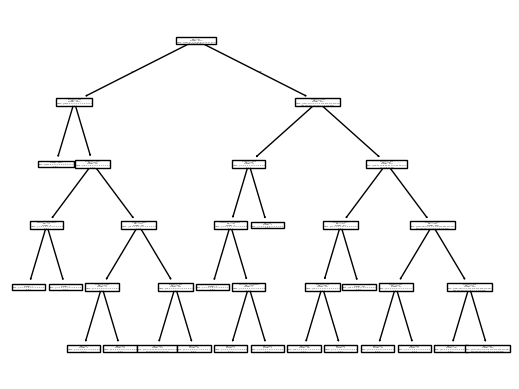

In [113]:
dtree = DecisionTreeClassifier(max_depth=5)
dtree = dtree.fit(x_train, y_train)
tree.plot_tree(dtree, feature_names=x.columns)
plt.show()

In [114]:
predicted_df = pd.DataFrame(dtree.predict(x_test))
predicted_df = predicted_df.rename(columns={0 : 'Predicted_ScrapReasonID'})
model_results_frame = pd.concat([y_test.reset_index()['ScrapReasonID'], predicted_df], axis=1)
model_results_frame

,ScrapReasonID,Predicted_ScrapReasonID
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
10884,0,0
10885,0,0
10886,0,0
10887,0,0


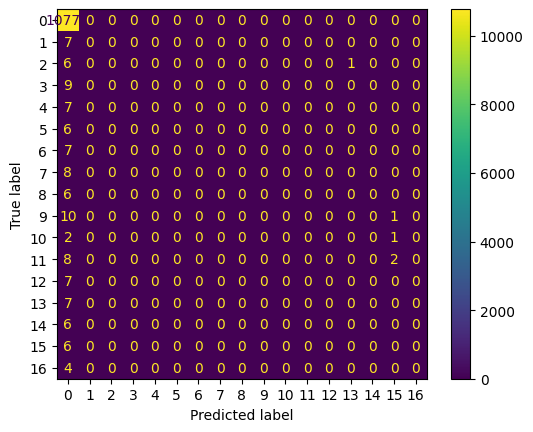

In [115]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming model_results_frame is already defined and has the necessary columns
# 'ScrapReasonID' for actual labels and 'Predicted_ScrapReasonID'
actual = model_results_frame['ScrapReasonID']
predicted = model_results_frame['Predicted_ScrapReasonID']

# Determine unique classes from the data
unique_classes = sorted(list(set(actual) | set(predicted)))

# Generate the confusion matrix
confusion_matrix = metrics.confusion_matrix(actual, predicted)

# Create a confusion matrix display
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=unique_classes)

# Plot the confusion matrix
cm_display.plot()
plt.show()

In [116]:
metrics.accuracy_score(model_results_frame['ScrapReasonID'], model_results_frame['Predicted_ScrapReasonID'])

0.9898062264670768

## Regression Model
AENC

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import sqlite3


In [88]:
sales_order['split'] = sales_order['order_date'].astype(str).str.split(" ").str.get(0)
sales_order['YEAR'] = sales_order['split'].astype(str).str.split("-").str.get(2)
sales_order['MONTH'] = sales_order['split'].astype(str).str.split("-").str.get(1)

sales_order = sales_order.loc[:,['prod_id', 'quantity', 'YEAR', 'MONTH']]
sales_order



,prod_id,quantity,YEAR,MONTH
0,300,12,1996,Mar
1,301,12,1996,Mar
2,302,12,1996,Mar
3,400,24,1996,Mar
4,401,24,1996,Mar
...,...,...,...,...
1098,300,10,1998,Nov
1099,301,0,1999,Jan
1100,301,15,1999,Feb
1101,302,3,1999,Feb


In [90]:
sales_order['prod_id'] = sales_order['prod_id'].astype(int)
sales_order['YEAR'] = sales_order['YEAR'].astype(int)
sales_order['quantity'] = sales_order['quantity'].astype(int)
sales_order = sales_order.groupby(['prod_id', 'YEAR', 'MONTH'])
sales_order = sales_order.aggregate('sum').reset_index()

sales_order

,prod_id,YEAR,MONTH,quantity
0,300,1996,Apr,36
1,300,1996,Aug,12
2,300,1996,Jul,24
3,300,1996,Jun,12
4,300,1996,Mar,60
...,...,...,...,...
286,700,1998,Mar,252
287,700,1998,May,204
288,700,1998,Nov,252
289,700,1998,Oct,264


<bound method DataFrame.reset_index of Empty DataFrame
Columns: []
Index: [(2001, 1996, Mar, 121212), (2002, 1996, Mar, 2424), (2003, 1996, Mar, 121212), (2004, 1996, Mar, 4848), (2005, 1996, Mar, 12), (2006, 1996, Mar, 48), (2007, 1996, Mar, 24), (2008, 1996, Mar, 12), (2009, 1996, Apr, 12), (2010, 1996, Apr, 12), (2011, 1996, Apr, 36), (2012, 1996, Apr, 12), (2013, 1996, Apr, 2424), (2014, 1996, Apr, 36), (2015, 1996, Apr, 24242424), (2016, 1996, Apr, 12121212), (2017, 1996, Apr, 484848), (2018, 1996, Apr, 60), (2019, 1996, Apr, 12), (2020, 1996, Apr, 24), (2021, 1996, Apr, 12), (2022, 1996, Apr, 24), (2023, 1996, May, 24), (2024, 1996, May, 36), (2025, 1996, May, 12), (2026, 1996, May, 4848), (2027, 1996, May, 12), (2028, 1996, May, 24), (2029, 1996, May, 48), (2030, 1996, May, 24242424), (2031, 1996, May, 4848), (2032, 1996, May, 60), (2033, 1996, May, 2424), (2035, 1996, Jun, 36), (2036, 1996, Jun, 12), (2037, 1996, Jun, 12), (2038, 1996, Jun, 60), (2039, 1996, Jun, 12), (2040, 19

In [91]:

month_dummies = pd.get_dummies(sales_order.loc[:, ['MONTH']])

sales_order = pd.concat([sales_order, month_dummies], axis=1)
sales_order.drop(['MONTH'], axis=1)


,prod_id,YEAR,quantity,MONTH_Apr,MONTH_Aug,MONTH_Dec,MONTH_Feb,MONTH_Jan,MONTH_Jul,MONTH_Jun,MONTH_Mar,MONTH_May,MONTH_Nov,MONTH_Oct,MONTH_Sep
0,300,1996,36,True,False,False,False,False,False,False,False,False,False,False,False
1,300,1996,12,False,True,False,False,False,False,False,False,False,False,False,False
2,300,1996,24,False,False,False,False,False,True,False,False,False,False,False,False
3,300,1996,12,False,False,False,False,False,False,True,False,False,False,False,False
4,300,1996,60,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,700,1998,252,False,False,False,False,False,False,False,True,False,False,False,False
287,700,1998,204,False,False,False,False,False,False,False,False,True,False,False,False
288,700,1998,252,False,False,False,False,False,False,False,False,False,True,False,False
289,700,1998,264,False,False,False,False,False,False,False,False,False,False,True,False


In [92]:
x = sales_order.drop('quantity', axis=1)
y = sales_order.loc[:,['quantity']]

x = x.rename(columns=str.lower)
x = x.drop(['month'], axis=1)
x

,prod_id,year,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,300,1996,True,False,False,False,False,False,False,False,False,False,False,False
1,300,1996,False,True,False,False,False,False,False,False,False,False,False,False
2,300,1996,False,False,False,False,False,True,False,False,False,False,False,False
3,300,1996,False,False,False,False,False,False,True,False,False,False,False,False
4,300,1996,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,700,1998,False,False,False,False,False,False,False,True,False,False,False,False
287,700,1998,False,False,False,False,False,False,False,False,True,False,False,False
288,700,1998,False,False,False,False,False,False,False,False,False,True,False,False
289,700,1998,False,False,False,False,False,False,False,False,False,False,True,False


In [93]:
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.15, 
    random_state=42
    )

In [94]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(x_train,y_train)
reg_model

LinearRegression()

In [95]:
y_pred = reg_model.predict(x_test)
y_pred

array([[125.15942494],
       [171.96508823],
       [107.06920277],
       [ 22.10508626],
       [101.54064711],
       [ 32.62811922],
       [ 97.47676389],
       [127.79705586],
       [ 92.22229327],
       [ 51.30707712],
       [149.69619937],
       [124.2637721 ],
       [-12.07455774],
       [129.86488235],
       [165.17898825],
       [104.0414678 ],
       [ 87.59113486],
       [ 21.92724579],
       [122.62454623],
       [ 43.18898538],
       [ -1.47963355],
       [ 48.935433  ],
       [130.94392284],
       [ 92.47899955],
       [107.17515201],
       [200.85309059],
       [ 71.95087995],
       [ 76.28691552],
       [  1.02118714],
       [146.24332406],
       [ 81.99002461],
       [158.5793431 ],
       [123.46102028],
       [149.59025013],
       [132.69741312],
       [125.01941768],
       [146.20926605],
       [101.43469787],
       [103.07392374],
       [ 17.25660969],
       [169.17426729],
       [ 37.26598426],
       [ 97.83280993],
       [ 35

In [96]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns={0: 'predicted_quantity'})
prediction_df

,predicted_quantity
0,125.159425
1,171.965088
2,107.069203
3,22.105086
4,101.540647
5,32.628119
6,97.476764
7,127.797056
8,92.222293
9,51.307077


In [97]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['quantity'], prediction_df], axis=1)
y_test_prediction_merge.loc[y_test_prediction_merge['predicted_quantity'].notna(),:]

,quantity,predicted_quantity
0,168,125.159425
1,168,171.965088
2,108,107.069203
3,24,22.105086
4,24,101.540647
5,108,32.628119
6,156,97.476764
7,8,127.797056
8,120,92.222293
9,24,51.307077


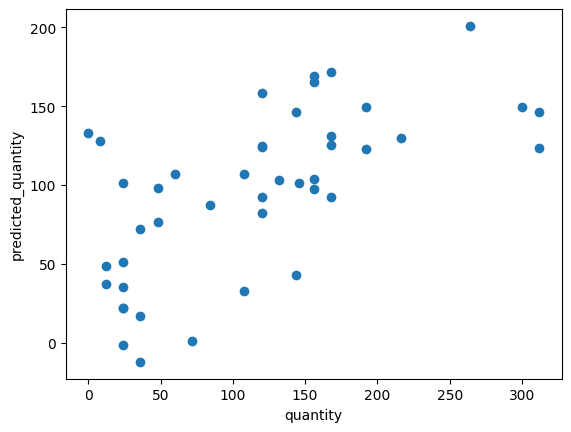

In [98]:
plt.scatter(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'])
plt.xlabel('quantity')
plt.ylabel('predicted_quantity')
plt.show()

In [99]:
mean_squared_error(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'])

4486.7857468167485

In [100]:

mean_absolute_error(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'])

49.71394055366446

NORTHWIND

In [112]:

orders['YEAR'] = orders['OrderDate'].astype(str).str.split("-").str.get(0)
orders['MONTH'] = orders['OrderDate'].astype(str).str.split("-").str.get(1)



In [113]:
orders = orders.loc[:,['ProductID', 'Quantity', 'YEAR', 'MONTH']]
orders

,ProductID,Quantity,YEAR,MONTH
0,11,12,1996,07
1,42,10,1996,07
2,72,5,1996,07
3,14,9,1996,07
4,51,40,1996,07
...,...,...,...,...
2150,64,2,1998,05
2151,66,1,1998,05
2152,73,2,1998,05
2153,75,4,1998,05


In [114]:
orders['ProductID'] = orders['ProductID'].astype(int)
orders['YEAR'] = orders['YEAR'].astype(int)
orders['Quantity'] = orders['Quantity'].astype(int)
orders = orders.groupby(['ProductID', 'YEAR', 'MONTH'])
orders = orders.aggregate('sum').reset_index()
orders

,ProductID,YEAR,MONTH,Quantity
0,1,1996,08,63
1,1,1996,09,20
2,1,1996,11,27
3,1,1996,12,15
4,1,1997,01,34
...,...,...,...,...
1157,77,1998,01,52
1158,77,1998,02,65
1159,77,1998,03,70
1160,77,1998,04,79


In [115]:
month_dummies = pd.get_dummies(orders.loc[:, ['MONTH']]) 
orders = pd.concat([orders, month_dummies], axis=1)
orders.drop(['MONTH'], axis=1)

,ProductID,YEAR,Quantity,MONTH_01,MONTH_02,MONTH_03,MONTH_04,MONTH_05,MONTH_06,MONTH_07,MONTH_08,MONTH_09,MONTH_10,MONTH_11,MONTH_12
0,1,1996,63,False,False,False,False,False,False,False,True,False,False,False,False
1,1,1996,20,False,False,False,False,False,False,False,False,True,False,False,False
2,1,1996,27,False,False,False,False,False,False,False,False,False,False,True,False
3,1,1996,15,False,False,False,False,False,False,False,False,False,False,False,True
4,1,1997,34,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,77,1998,52,True,False,False,False,False,False,False,False,False,False,False,False
1158,77,1998,65,False,True,False,False,False,False,False,False,False,False,False,False
1159,77,1998,70,False,False,True,False,False,False,False,False,False,False,False,False
1160,77,1998,79,False,False,False,True,False,False,False,False,False,False,False,False


In [116]:
x = orders.drop('Quantity', axis=1)
y = orders.loc[:,['Quantity']]
x = x.rename(columns=str.lower)
x = x.drop(['month'], axis=1)
x

,productid,year,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,1,1996,False,False,False,False,False,False,False,True,False,False,False,False
1,1,1996,False,False,False,False,False,False,False,False,True,False,False,False
2,1,1996,False,False,False,False,False,False,False,False,False,False,True,False
3,1,1996,False,False,False,False,False,False,False,False,False,False,False,True
4,1,1997,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,77,1998,True,False,False,False,False,False,False,False,False,False,False,False
1158,77,1998,False,True,False,False,False,False,False,False,False,False,False,False
1159,77,1998,False,False,True,False,False,False,False,False,False,False,False,False
1160,77,1998,False,False,False,True,False,False,False,False,False,False,False,False


In [117]:
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.15, 
    random_state=12
    )

In [118]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(x_train,y_train)
reg_model

LinearRegression()

In [119]:
y_pred = reg_model.predict(x_test)
y_pred

array([[50.68164658],
       [49.00561882],
       [47.49795412],
       [38.27990046],
       [61.0505706 ],
       [26.14665535],
       [50.73673049],
       [57.0392047 ],
       [49.50776045],
       [37.22413702],
       [44.13547647],
       [43.65003643],
       [62.27954064],
       [48.42245921],
       [38.26265584],
       [30.27480777],
       [47.83312777],
       [57.7551536 ],
       [55.58678556],
       [43.44118706],
       [31.50943371],
       [56.44204011],
       [39.37990133],
       [55.63238716],
       [60.71539695],
       [53.13958666],
       [51.22952814],
       [57.41997995],
       [47.71066204],
       [44.0344931 ],
       [34.44781805],
       [38.87046746],
       [28.71631998],
       [57.3082554 ],
       [40.68275663],
       [26.9287272 ],
       [62.72643884],
       [47.225222  ],
       [46.68119899],
       [49.67596611],
       [45.93381043],
       [43.41939136],
       [48.78936569],
       [37.88948337],
       [40.99323389],
       [24

In [120]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns={0: 'predicted_quantity'})
prediction_df

,predicted_quantity
0,50.681647
1,49.005619
2,47.497954
3,38.279900
4,61.050571
...,...
170,42.547391
171,42.571333
172,52.727549
173,44.956504


In [121]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['Quantity'], prediction_df], axis=1)
y_test_prediction_merge.loc[y_test_prediction_merge['predicted_quantity'].notna(),:]

,Quantity,predicted_quantity
0,164,50.681647
1,40,49.005619
2,82,47.497954
3,19,38.279900
4,15,61.050571
...,...,...
170,44,42.547391
171,16,42.571333
172,120,52.727549
173,85,44.956504


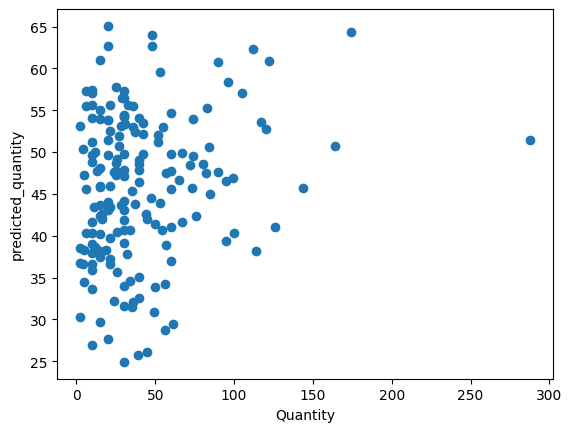

In [122]:
plt.scatter(y_test_prediction_merge['Quantity'], y_test_prediction_merge['predicted_quantity'])
plt.xlabel('Quantity')
plt.ylabel('predicted_quantity')
plt.show()

In [ ]:
mean_squared_error(y_test_prediction_merge['Quantity'], y_test_prediction_merge['predicted_quantity'])


In [ ]:
mean_absolute_error(y_test_prediction_merge['Quantity'], y_test_prediction_merge['predicted_quantity'])

AdeventureWorks


In [139]:
salesorder = pd.merge(salesOrderHeader, salesOrderDetail, on='SalesOrderID')
salesorder

,SalesOrderID,RevisionNumber,OrderDate,DueDate,ShipDate,Status,OnlineOrderFlag,SalesOrderNumber,PurchaseOrderNumber,AccountNumber,CustomerID,SalesPersonID,TerritoryID,BillToAddressID,ShipToAddressID,ShipMethodID,CreditCardID,CreditCardApprovalCode,CurrencyRateID,SubTotal,TaxAmt,Freight,TotalDue,Comment,rowguid_x,ModifiedDate_x,SalesOrderDetailID,CarrierTrackingNumber,OrderQty,ProductID,SpecialOfferID,UnitPrice,UnitPriceDiscount,LineTotal,rowguid_y,ModifiedDate_y
0,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,29825,279.0,5,985,985,5,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07,1,4911-403C-98,1,776,1,2024.994,0.0,2024.994,B207C96D-D9E6-402B-8470-2CC176C42283,2011-05-31
1,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,29825,279.0,5,985,985,5,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07,2,4911-403C-98,3,777,1,2024.994,0.0,6074.982,7ABB600D-1E77-41BE-9FE5-B9142CFC08FA,2011-05-31
2,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,29825,279.0,5,985,985,5,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07,3,4911-403C-98,1,778,1,2024.994,0.0,2024.994,475CF8C6-49F6-486E-B0AD-AFC6A50CDD2F,2011-05-31
3,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,29825,279.0,5,985,985,5,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07,4,4911-403C-98,1,771,1,2039.994,0.0,2039.994,04C4DE91-5815-45D6-8670-F462719FBCE3,2011-05-31
4,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,29825,279.0,5,985,985,5,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07,5,4911-403C-98,1,772,1,2039.994,0.0,2039.994,5A74C7D2-E641-438E-A7AC-37BF23280301,2011-05-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121312,75122,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75122,None,10-4030-015868,15868,NaN,6,14616,14616,1,18719.0,330022Vi97312,NaN,30.9700,2.4776,0.7743,34.2219,None,4221035A-4159-492F-AF40-4363A64FFC16,2014-07-07,121313,None,1,878,1,21.980,0.0,21.980,8CAD6675-18CC-4F47-8287-97B41A8EE47D,2014-06-30
121313,75122,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75122,None,10-4030-015868,15868,NaN,6,14616,14616,1,18719.0,330022Vi97312,NaN,30.9700,2.4776,0.7743,34.2219,None,4221035A-4159-492F-AF40-4363A64FFC16,2014-07-07,121314,None,1,712,1,8.990,0.0,8.990,84F1C363-1C50-4442-BE16-541C59B6E12C,2014-06-30
121314,75123,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75123,None,10-4030-018759,18759,NaN,6,14024,14024,1,10084.0,230370Vi51970,NaN,189.9700,15.1976,4.7493,209.9169,None,D54752FF-2B54-4BE5-95EA-3B72289C059F,2014-07-07,121315,None,1,878,1,21.980,0.0,21.980,C18B6476-429F-4BB1-828E-2BE5F82A0A51,2014-06-30
121315,75123,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75123,None,10-4030-018759,18759,NaN,6,14024,14024,1,10084.0,230370Vi51970,NaN,189.9700,15.1976,4.7493,209.9169,None,D54752FF-2B54-4BE5-95EA-3B72289C059F,2014-07-07,121316,None,1,879,1,159.000,0.0,159.000,75A89C6A-C60A-47EA-8A52-B52A9C435B64,2014-06-30


In [140]:
salesorder['YEAR'] = salesorder['OrderDate'].astype(str).str.split("-").str.get(0)
salesorder['MONTH'] = salesorder['OrderDate'].astype(str).str.split("-").str.get(1)
#salesorder['MONTH'] = salesorder['MONTH'].str.replace("0","")
salesorder

,SalesOrderID,RevisionNumber,OrderDate,DueDate,ShipDate,Status,OnlineOrderFlag,SalesOrderNumber,PurchaseOrderNumber,AccountNumber,CustomerID,SalesPersonID,TerritoryID,BillToAddressID,ShipToAddressID,ShipMethodID,CreditCardID,CreditCardApprovalCode,CurrencyRateID,SubTotal,TaxAmt,Freight,TotalDue,Comment,rowguid_x,ModifiedDate_x,SalesOrderDetailID,CarrierTrackingNumber,OrderQty,ProductID,SpecialOfferID,UnitPrice,UnitPriceDiscount,LineTotal,rowguid_y,ModifiedDate_y,YEAR,MONTH
0,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,29825,279.0,5,985,985,5,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07,1,4911-403C-98,1,776,1,2024.994,0.0,2024.994,B207C96D-D9E6-402B-8470-2CC176C42283,2011-05-31,2011,05
1,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,29825,279.0,5,985,985,5,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07,2,4911-403C-98,3,777,1,2024.994,0.0,6074.982,7ABB600D-1E77-41BE-9FE5-B9142CFC08FA,2011-05-31,2011,05
2,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,29825,279.0,5,985,985,5,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07,3,4911-403C-98,1,778,1,2024.994,0.0,2024.994,475CF8C6-49F6-486E-B0AD-AFC6A50CDD2F,2011-05-31,2011,05
3,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,29825,279.0,5,985,985,5,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07,4,4911-403C-98,1,771,1,2039.994,0.0,2039.994,04C4DE91-5815-45D6-8670-F462719FBCE3,2011-05-31,2011,05
4,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,29825,279.0,5,985,985,5,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07,5,4911-403C-98,1,772,1,2039.994,0.0,2039.994,5A74C7D2-E641-438E-A7AC-37BF23280301,2011-05-31,2011,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121312,75122,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75122,None,10-4030-015868,15868,NaN,6,14616,14616,1,18719.0,330022Vi97312,NaN,30.9700,2.4776,0.7743,34.2219,None,4221035A-4159-492F-AF40-4363A64FFC16,2014-07-07,121313,None,1,878,1,21.980,0.0,21.980,8CAD6675-18CC-4F47-8287-97B41A8EE47D,2014-06-30,2014,06
121313,75122,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75122,None,10-4030-015868,15868,NaN,6,14616,14616,1,18719.0,330022Vi97312,NaN,30.9700,2.4776,0.7743,34.2219,None,4221035A-4159-492F-AF40-4363A64FFC16,2014-07-07,121314,None,1,712,1,8.990,0.0,8.990,84F1C363-1C50-4442-BE16-541C59B6E12C,2014-06-30,2014,06
121314,75123,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75123,None,10-4030-018759,18759,NaN,6,14024,14024,1,10084.0,230370Vi51970,NaN,189.9700,15.1976,4.7493,209.9169,None,D54752FF-2B54-4BE5-95EA-3B72289C059F,2014-07-07,121315,None,1,878,1,21.980,0.0,21.980,C18B6476-429F-4BB1-828E-2BE5F82A0A51,2014-06-30,2014,06
121315,75123,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75123,None,10-4030-018759,18759,NaN,6,14024,14024,1,10084.0,230370Vi51970,NaN,189.9700,15.1976,4.7493,209.9169,None,D54752FF-2B54-4BE5-95EA-3B72289C059F,2014-07-07,121316,None,1,879,1,159.000,0.0,159.000,75A89C6A-C60A-47EA-8A52-B52A9C435B64,2014-06-30,2014,06


In [141]:
salesorder = salesorder.loc[:, ['ProductID', 'YEAR', 'MONTH', 'OrderQty']]
salesorder

,ProductID,YEAR,MONTH,OrderQty
0,776,2011,05,1
1,777,2011,05,3
2,778,2011,05,1
3,771,2011,05,1
4,772,2011,05,1
...,...,...,...,...
121312,878,2014,06,1
121313,712,2014,06,1
121314,878,2014,06,1
121315,879,2014,06,1


In [142]:
salesorder['ProductID'] = salesorder['ProductID'].astype(int)
salesorder['YEAR'] = salesorder['YEAR'].astype(int)
salesorder['OrderQty'] = salesorder['OrderQty'].astype(int)
salesorder = salesorder.groupby(['ProductID', 'YEAR', 'MONTH'])
salesorder = salesorder.aggregate('sum').reset_index()
salesorder


,ProductID,YEAR,MONTH,OrderQty
0,707,2011,05,24
1,707,2011,07,58
2,707,2011,08,96
3,707,2011,10,141
4,707,2011,12,12
...,...,...,...,...
3857,999,2014,01,96
3858,999,2014,02,38
3859,999,2014,03,210
3860,999,2014,04,43


In [143]:
month_dummies = pd.get_dummies(salesorder.loc[:, ['MONTH']])
salesorder = pd.concat([salesorder, month_dummies], axis=1)
salesorder.drop(['MONTH'], axis=1)


,ProductID,YEAR,OrderQty,MONTH_01,MONTH_02,MONTH_03,MONTH_04,MONTH_05,MONTH_06,MONTH_07,MONTH_08,MONTH_09,MONTH_10,MONTH_11,MONTH_12
0,707,2011,24,False,False,False,False,True,False,False,False,False,False,False,False
1,707,2011,58,False,False,False,False,False,False,True,False,False,False,False,False
2,707,2011,96,False,False,False,False,False,False,False,True,False,False,False,False
3,707,2011,141,False,False,False,False,False,False,False,False,False,True,False,False
4,707,2011,12,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,999,2014,96,True,False,False,False,False,False,False,False,False,False,False,False
3858,999,2014,38,False,True,False,False,False,False,False,False,False,False,False,False
3859,999,2014,210,False,False,True,False,False,False,False,False,False,False,False,False
3860,999,2014,43,False,False,False,True,False,False,False,False,False,False,False,False


In [147]:
x = salesorder.drop('OrderQty', axis=1)
y = salesorder.loc[:,['OrderQty']]


In [203]:
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.1, 
    random_state=1000
    )

In [204]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(x_train,y_train)
reg_model

LinearRegression()

In [205]:
y_pred = reg_model.predict(x_test)
y_pred

array([[ 60.1037519 ],
       [ 51.54327499],
       [ 63.3627586 ],
       [ 97.55942806],
       [ 88.26445176],
       [ 89.6805964 ],
       [ 55.53118488],
       [ 47.9892285 ],
       [ 42.13489768],
       [ 95.46127746],
       [ 63.70059712],
       [100.93265101],
       [ 56.20086468],
       [107.26151728],
       [ 70.47227799],
       [ 34.70868553],
       [ 63.78948689],
       [107.74808969],
       [ 75.54927014],
       [ 75.94684137],
       [ 54.30736834],
       [ 53.41589326],
       [ 89.2093754 ],
       [ 53.60554056],
       [105.49060408],
       [ 49.91795057],
       [ 88.44341191],
       [ 35.57547433],
       [ 58.60250891],
       [103.35863006],
       [ 56.73334739],
       [ 89.22621383],
       [ 44.07757948],
       [ 33.45786424],
       [ 69.0803925 ],
       [ 69.14263136],
       [ 86.01743286],
       [ 76.26021481],
       [ 30.13808314],
       [ 89.83790035],
       [ 63.83729405],
       [119.73282798],
       [ 26.35485536],
       [ 87

In [206]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns={0: 'predicted_OrderQty'})
prediction_df

,predicted_OrderQty
0,60.103752
1,51.543275
2,63.362759
3,97.559428
4,88.264452
...,...
382,75.744415
383,79.104961
384,65.350642
385,52.724662


In [207]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['OrderQty'], prediction_df], axis=1)
y_test_prediction_merge.loc[y_test_prediction_merge['predicted_OrderQty'].notna(),:]

,OrderQty,predicted_OrderQty
0,34,60.103752
1,36,51.543275
2,240,63.362759
3,125,97.559428
4,182,88.264452
...,...,...
382,8,75.744415
383,66,79.104961
384,3,65.350642
385,1,52.724662


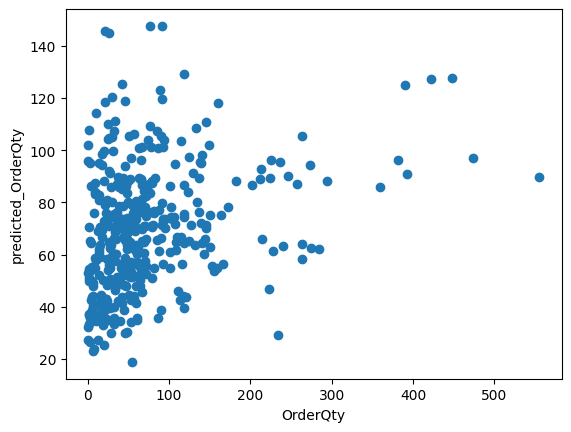

In [208]:
plt.scatter(y_test_prediction_merge['OrderQty'], y_test_prediction_merge['predicted_OrderQty'])
plt.xlabel('OrderQty')
plt.ylabel('predicted_OrderQty')
plt.show()

In [210]:
mean_squared_error(y_test_prediction_merge['OrderQty'], y_test_prediction_merge['predicted_OrderQty'])


5487.59166280932

In [ ]:
mean_absolute_error(y_test_prediction_merge['OrderQty'], y_test_prediction_merge['predicted_OrderQty'])

## Cluster

In [ ]:
AW_order_detail = pd.read_sql_query("SELECT * FROM [AW.SalesOrderDetail]", dwh)
AW_order_detail

In [ ]:
order_full = AW_order_detail
order_full['SALESORDERDETAIL_OrderQty'] = order_full['SALESORDERDETAIL_OrderQty'].astype(float)
order_full['SALESORDERDETAIL_UnitPrice'] = order_full['SALESORDERDETAIL_UnitPrice'].astype(float)
order_full

In [ ]:
table = order_full[['SALESORDERDETAIL_OrderQty', 'SALESORDERDETAIL_UnitPrice']]
df = pd.get_dummies(table)  
table = pd.concat([table, df], axis=1)

In [ ]:
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans.fit_predict(df)

In [ ]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

In [ ]:
for src_index, _ in df.iterrows():
    if src_index not in df.index:
        continue  # Skip if src_index is not in df's index

    euclidian_distances = {}
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        if centrumindex not in kmeans_centra.index:
            continue  # Skip if centrumindex is not in kmeans_centra's index

        euclidian_sum = 0
        for column_name in kmeans_centra.columns:
            if column_name in df.columns and column_name in kmeans_centra.columns:
                current_difference = df.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
                euclidian_sum += current_difference ** 2
                print(f'\t\t{df.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            else:
                print(f"Column {column_name} not found in both DataFrames.")
        
        euclidian_distance = math.sqrt(euclidian_sum)
        euclidian_distances[centrumindex] = euclidian_distance
        print(f'\tCentrumindex {centrumindex}: Euclidische afstand = {euclidian_distance}')
        print('------------------------------------------------')
    
    if euclidian_distances:
        centrum_number = min(euclidian_distances, key=euclidian_distances.get)
        df.at[src_index, 'Centrum'] = centrum_number
        print("================================================")

In [ ]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df.columns[i]}'})
    
kmeans_centra

In [ ]:
plt.scatter(df['SALESORDERDETAIL_OrderQty'], df['SALESORDERDETAIL_UnitPrice'], color = 'k')
plt.show()

In [ ]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

In [ ]:
kmeans1 = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

In [ ]:
df['Centrum'] = prediction_results
df

In [ ]:
df.groupby('Centrum', as_index = False)['Centrum'].count()